In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from itertools import cycle
#from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
plt.style.use('ggplot')   

from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
#tprs = []
#aucs = []
#base_fpr = np.linspace(0, 1, 101)






def test_model(modelo: GIN_classifier_to_explain_v2, loader: DataLoader, device: str = 'cpu'):
    
    modelo.eval()
    all_predictions = []
    all_true        = []
    tprs            = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    #correct = 0
    for i, val_data in enumerate(loader):
        
        assert not val_data.is_cuda
        if (device == 'cuda:0') | (device == 'cuda'):
            val_data.to(device, non_blocking=True) 
            assert val_data.is_cuda                          

        val_predictions = modelo(val_data.x, val_data.edge_index,  val_data.batch)# Make predictions for this batch
        pred            = val_predictions.argmax(dim=1)
        
        fpr, tpr, _ = roc_curve(pred.cpu().tolist(),  val_data.y.cpu().tolist())
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        
        
        #all_predictions.extend(pred.cpu().tolist())
        #all_true.extend(val_data.y.cpu().tolist())

    return tprs #all_predictions, all_true    #correct += int((pred == val_data.y).sum())
        


def get_plot_data(tprs):
    base_fpr = np.linspace(0, 1, 101)
    aucs = []
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    return base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc




def get_plot_params(model, loader_validation):
    

    model.eval()

    tprs = test_model(model, loader_validation, device = 'cuda:0')



    return get_plot_data(tprs)


#colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

#loader_path = "./results/dataloaders/loader_Concen_plus_Fluxes.pt"



#model       = torch.load(
#                   "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_05min_best_ValAcc_0.9894379479441721_epoch_9.pt")

model_Masked_Phe            = torch.load(
                                    "./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_12min_best_ValAcc_0.9200301772915881_epoch_83.pt")

loader_validation_Masked_Phe = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_validation_loader()



base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc = get_plot_params(model_Masked_Phe.to(device, non_blocking=True), loader_validation_Masked_Phe)



model_NON_Masked_Phe            = torch.load(
                                    "./results/trained_models/Non_masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_05min_best_ValAcc_0.9894379479441721_epoch_9.pt")

loader_validation_NON_Masked_Phe = torch.load("./results/dataloaders/loader_Concen_plus_Fluxes.pt").get_validation_loader()


base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 = get_plot_params(model_NON_Masked_Phe.to(device, non_blocking=True), loader_validation_NON_Masked_Phe)




/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


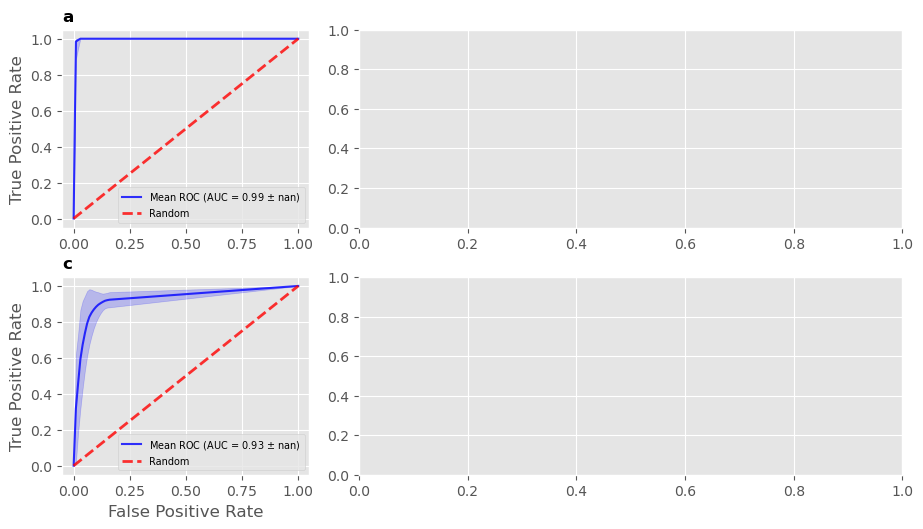

In [2]:

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=3)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=.8, top=0.99, wspace=0.2, hspace=0.25)



def put_in_subplot(base_fpr, mean_tprs, tprs_lower,
                   tprs_upper, mean_auc, std_auc, AX, xlabel:str='', letter:str=''):
    
    AX.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    AX.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
    AX.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Random', alpha= 0.8)

    #ax1.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])

    AX.legend(loc="lower right", fontsize=7)
    AX.set_ylabel('True Positive Rate')
    AX.set_xlabel(xlabel)
    AX.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')


put_in_subplot(base_fpr_2, mean_tprs_2, tprs_lower_2, tprs_upper_2, mean_auc_2, std_auc_2 , ax1, letter = 'a')

put_in_subplot(base_fpr, mean_tprs, tprs_lower, tprs_upper, mean_auc, std_auc, ax3, xlabel = 'False Positive Rate', letter = 'c')





## dummy model

In [3]:
from acevedo_clss_and_fcns import * 
from torch.utils.data import Dataset, DataLoader
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")

device = 'cuda:0'


In [4]:

    
metabolite_data  = pd.read_parquet("./results/dataframes/augmented_metabolite_data.parquet.gzip")
metabolite_names = pd.read_csv("./metabolites_data/metabolite_names.csv")


metabolite_data.rename(columns = metabolite_names.set_index("Simbolo_traductor")["Recon3_ID"].to_dict(), inplace=True)

metabolite_data.phe_L_c  = 0.0


X = metabolite_data.select_dtypes('float').to_numpy()
#y =  np.array([1 if l == 'PKU' else 0 for l in metabolite_data.label])
y = np.array(metabolite_data.label.to_list())
assert X.shape[0] == y.shape[0]

X.shape

(7572, 48)

In [5]:




class PKU_preprocesed_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transform=None):
        """
        """
        assert X.shape[0] == y.shape[0]
        
        self.X         = X
        self.y         = y
        self.transform = transform

    def __len__(self):
        return len(self.y )

    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        instance = self.X[idx,:]
        label  =  self.y[idx]
        
        


        return torch.tensor(instance).float(), torch.tensor(label).float()


X_train, X_0, y_train, y_0 = train_test_split(X, y, test_size=0.33, random_state=69)


X_val, X_test, y_val, y_test = train_test_split(X_0, y_0, test_size=0.33, random_state=69)

print(X_train.shape, y_train.shape , X_val.shape , y_val.shape , X_test.shape, y_test.shape)

train_dataloader = DataLoader(PKU_preprocesed_Dataset(X_train,y_train), batch_size=2*32, shuffle=True, drop_last=True)
val_dataloader   = DataLoader(PKU_preprocesed_Dataset(X_val,y_val), batch_size=2*32, shuffle=True, drop_last=True)








(5073, 48) (5073,) (1674, 48) (1674,) (825, 48) (825,)


In [6]:
import torch.nn as nn
from sklearn.metrics import roc_curve, auc

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(48, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
    
#model.to(device=device)
X_batch, y_batch = next(iter(train_dataloader))
X_batch, y_batch = X_batch.to(device), y_batch.to(device)
print(X_batch.shape)
model = BinaryClassification().to(device=device)
#X_batch[0].shape

#layer_1 = nn.Linear(48, 64) 
#layer_1(X_batch[0].float())

import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device=device)
model.train()
EPOCHS = 20
train_accuracy = []
val_accuracy   = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()        
        y_pred = model(X_batch)        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))        
        loss.backward()
        optimizer.step()        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    train_accuracy.append(epoch_acc/len(train_dataloader))
    
    model.eval()
    val_epoch_loss = 0
    val_epoch_acc = 0
    for X_batch, y_batch in val_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
        val_y_pred = model(X_batch)
            
        loss = criterion(val_y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(val_y_pred, y_batch.unsqueeze(1))

        val_epoch_loss += loss.item()
        val_epoch_acc += acc.item()
        
    val_accuracy.append(val_epoch_acc/len(val_dataloader))    


torch.Size([64, 48])


In [30]:
list(range(len(train_accuracy)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

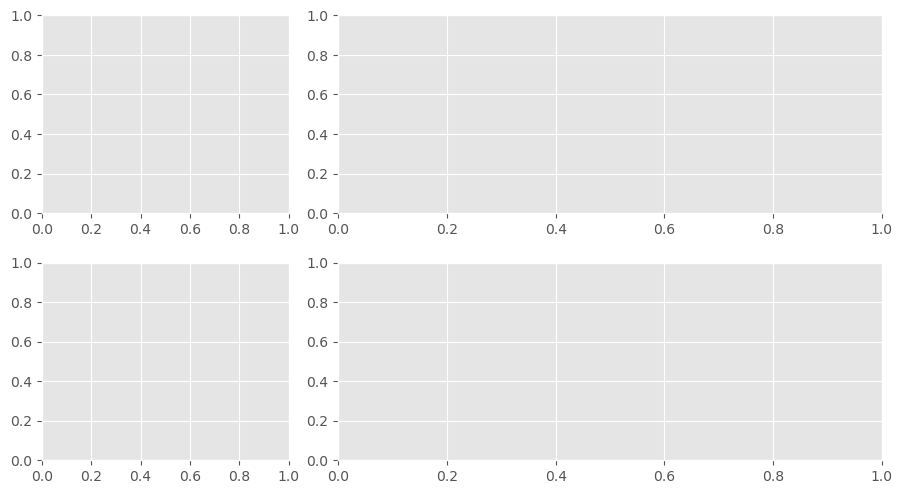

In [31]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=3)
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 3), (1, 1), colspan=3)
plt.subplots_adjust(left=0.1, bottom=0.1, right=.8, top=0.99, wspace=0.2, hspace=0.25)



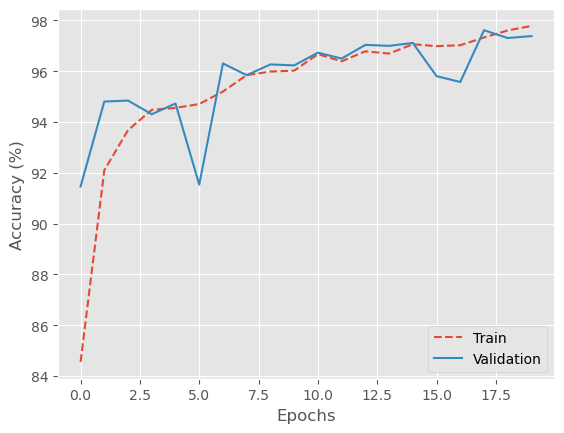

In [36]:
    
plt.plot(train_accuracy,  label = "Train", linestyle="--")
plt.plot(val_accuracy,  label = "Validation", linestyle="-")

plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.show()

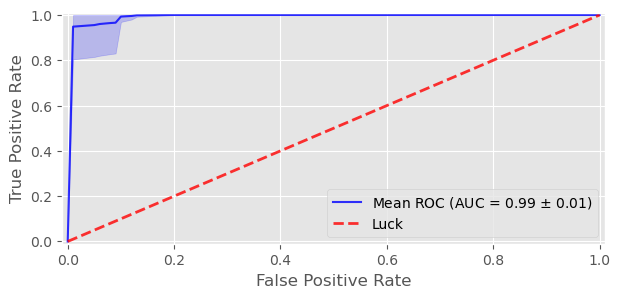

In [17]:
model.eval()
all_predictions = []
all_true        = []
tprs            = []
aucs = []
base_fpr = np.linspace(0, 1, 101)

test_dataloader  = DataLoader(PKU_preprocesed_Dataset(X_test,y_test), batch_size=32, shuffle=True, drop_last=True)


for X_batch, y_batch in test_dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)                       

    val_predictions = model(X_batch)# Make predictions for this batch
    #pred            = val_predictions.argmax(dim=1)
    
    #y_pred_tag = torch.round(torch.sigmoid(val_predictions)).squeeze().cpu().int().tolist()
    y_pred_tag = val_predictions.squeeze().cpu().int().tolist()
    y_true     = y_batch.squeeze().cpu().int().tolist()
    #print(y_true, y_pred_tag)    
    fpr, tpr, _ = roc_curve(y_true, y_pred_tag)
    
    
    #print(y_pred_tag, y_true, tpr)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
mean_auc = auc(base_fpr, mean_tprs)
std_auc = np.std(aucs)


tprs_upper = np.minimum(mean_tprs + tprs.std(axis=0), 1)
tprs_lower = mean_tprs - tprs.std(axis=0)
plt.figure(figsize=(7, 3))
plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'blue', alpha = 0.2)
plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'r', label = 'Luck', alpha= 0.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
#plt.title('Receiver operating characteristic (ROC) curve')
#plt.axes().set_aspect('equal', 'datalim')
plt.show()